# Предсказание удовлетворенности сотрудников и шансов увольнения сотрудников

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

## Цели работы

- Предсказание уровня удовлетворённости сотрудника
- Предсказание увольнения сотрудника из компании

В распоряжении имеются следующие данные:
- Тренировочная выборка для целевого парамтра удовлетворенности: `train_job_satisfaction_rate.csv`
- Тренировочная выборка для целевого параметра увольнения: `train_quit.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`
- Целевой признак тестовой выборки: `test_target_quit.csv`

Описание данных:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак;
- `quit` — увольнение сотрудника из компании.

## Ход работы

**Общий план исследования:**
- Загрузка данных
- Предобработка данных (оценка их качества и при необходимости исправление)
- Исследовательский анализ данных
- Разбивка и подготовка данных к обучению
- Обучение моделей
- Тестирование и верификации
- Выводы

### Подготовка к работе

In [33]:
!pip install phik -q
!pip install numpy==1.23.1 -q
!pip install numba -U -q
!pip install scikit-learn -U -q 
!pip install scipy -U -q 
!pip install shap -U -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.17 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.6.1 which is incompatible.
spacy 3.2.0 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.6.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numba<0.59.0,>=0.56.0, but you have numba 0.59.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numba<0.59.0,>=0.56.0, but you have numba 0.59.0 which is incompatible.
ydata-profiling 4.6.4 requires scipy<1.12,>=1.4.

In [34]:
RANDOM_STATE = 2024

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix

from scipy import stats as st

import shap

from phik.report import plot_correlation_matrix
from phik import report

import warnings

### Загрузка и обзор данных

#### Загрузка данных

In [35]:
satisfaction_train = pd.read_csv('...', sep=',', decimal='.')
satisfaction_test_y = pd.read_csv('...', sep=',', decimal='.')

features_test_X = pd.read_csv('...', sep=',', decimal='.')

quit_train = pd.read_csv('...', sep=',', decimal='.')
quit_test_y = pd.read_csv('...', sep=',', decimal='.')


#### Обзор данных

In [36]:
display(satisfaction_train.head())
display(quit_train.head())
display(satisfaction_test_y.head())
display(features_test_X.head())
display(quit_test_y.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Как видно данные совпадают с предоставленным описанием структуры данных.

### Предобработка данных

В этом разделе рассмотрим пропуски в данных и проведем необходимые преобразования типов и добавим необходимые столбцы.

#### Рассмотрение пропусков в данных

Для удобства объединим таблицы `test_features.csv`, `test_target_job_satisfaction_rate.csv` , `test_target_quit.csv`

In [37]:
test = features_test_X.merge(quit_test_y, on='id', how='outer').merge(satisfaction_test_y, on='id', how='outer')
display(test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,yes,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,yes,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,no,0.43


Рассмотрим в каких каких столбцах сколько пропусков находится

In [38]:
print('Число пропусков в satisfaction_train')
print(satisfaction_train.isna().sum())

print('Число пропусков в quit_train')
print(quit_train.isna().sum())

print('Число пропусков в test')
print(test.isna().sum())

Число пропусков в satisfaction_train
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Число пропусков в quit_train
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Число пропусков в test
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
job_satisfaction_rate    0
dtype: int64


В `test` и `satisfaction_train` обнаружилось несколько пропусков в столбцах `dept` и `level`, рассмотрим их

In [39]:
display(satisfaction_train[(satisfaction_train.isna()['dept'])|(satisfaction_train.isna()['level'])])

display(test[(test.isna()['dept'])|(test.isna()['level'])])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
191,609865,NaN,junior,medium,1,no,no,1,20400,yes,0.12
312,471990,sales,NaN,low,1,no,no,3,12000,yes,0.17
1196,832342,NaN,junior,medium,1,no,no,4,28800,no,0.61


Заметим, что пропуск в столбце `level` только у работников департамента продаж, а пропуски в `dept` только у джуниоров.

Назвать пропуски однозначно ошибочными сложно, возможно данные работники не вписываются в используемую в данных упрощенную классификацию. Оставим пропуски как есть

#### Явные дубликаты
В данном разделе рассмотрим наличие явных и неявных дубликатов в данных.

In [40]:
print('Дубликаты в satisfaction_train:', satisfaction_train.duplicated().sum())
print('Дубликаты в quit_train:', quit_train.duplicated().sum())
print('Дубликаты в test:', test.duplicated().sum())

print('Повторяющиеся id в satisfaction_train:', satisfaction_train['id'].duplicated().sum())
print('Повторяющиеся id в quit_train:', quit_train['id'].duplicated().sum())
print('Повторяющиеся id в test:', test['id'].duplicated().sum())

Дубликаты в satisfaction_train: 0
Дубликаты в quit_train: 0
Дубликаты в test: 0
Повторяющиеся id в satisfaction_train: 0
Повторяющиеся id в quit_train: 0
Повторяющиеся id в test: 0


Явных дубликатов в данных нет. 

Рассмотрим различные значения категориальных параметров на предмет наличия неявных дубликатов

In [41]:
print('satisfaction_train')
for c in satisfaction_train.select_dtypes(include='object'):
    print('    ', c, ': ', satisfaction_train[c].unique())

print('quit_train')
for c in quit_train.select_dtypes(include='object'):
    print('    ', c, ': ', quit_train[c].unique())
    
print('test')
for c in test.select_dtypes(include='object'):
    print('    ', c, ': ', test[c].unique())

satisfaction_train
     dept :  ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
     level :  ['junior' 'middle' 'sinior' nan]
     workload :  ['medium' 'high' 'low']
     last_year_promo :  ['no' 'yes']
     last_year_violations :  ['no' 'yes']
quit_train
     dept :  ['sales' 'purchasing' 'marketing' 'technology' 'hr']
     level :  ['middle' 'junior' 'sinior']
     workload :  ['high' 'medium' 'low']
     last_year_promo :  ['no' 'yes']
     last_year_violations :  ['no' 'yes']
     quit :  ['no' 'yes']
test
     dept :  ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
     level :  ['junior' 'middle' 'sinior' nan]
     workload :  ['medium' 'low' 'high' ' ']
     last_year_promo :  ['no' 'yes']
     last_year_violations :  ['no' 'yes']
     quit :  ['no' 'yes']


Неявных дубликатов нет.

Исправим опечатку в `senior`

In [42]:
satisfaction_train = satisfaction_train.replace('sinior', 'senior')
quit_train = quit_train.replace('sinior', 'senior')
test = test.replace('sinior', 'senior')

В тестовых данных есть значения состоящие из одного пробела, рассмотрим их

In [43]:
display(test[(test['dept']==' ')|(test['workload']==' ')])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
15,590867,marketing,junior,,4,no,no,4,28800,no,0.79
1699,822186,,middle,medium,3,no,no,4,38400,no,0.64


Не будем удалять такие значения т.к. готовой модели придется работать с данными различного качества. Для удобства обработки заменим их на NaN

In [44]:
test = test.replace(' ', np.nan)

#### Итоги предобработки данных
В ходе предобработки не были обнаружены дубликаты и были обнаружены пропуски в данных, которые будут обработаны на этапе подготовки данных к обучению.

### Исследовательский анализ данных

Опишем общую информацию о распределениях данных в таблицах

#### Категориальные переменные в `satisfaction_train`

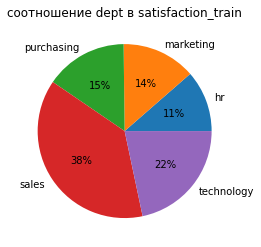

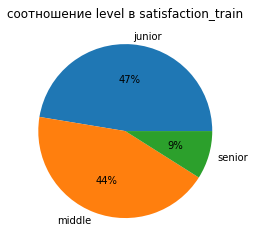

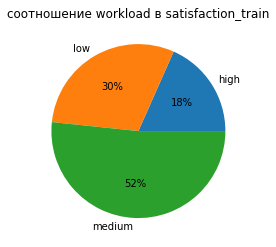

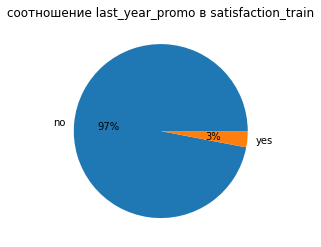

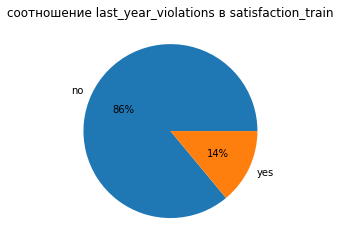

In [45]:
df = satisfaction_train

for c in df.select_dtypes(include='object'):
    df.pivot_table(index=c, aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+c+' в satisfaction_train')
    plt.show()

#### Количественные переменные в `satisfaction_train`

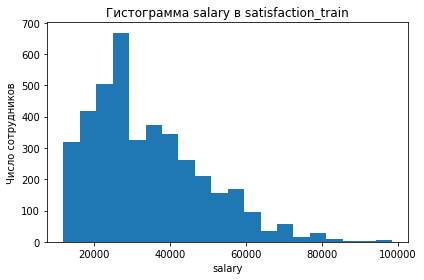

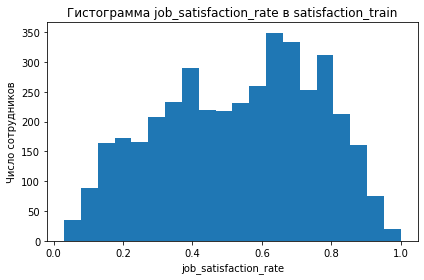

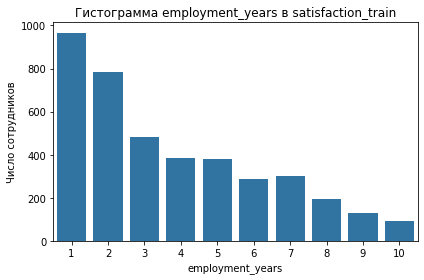

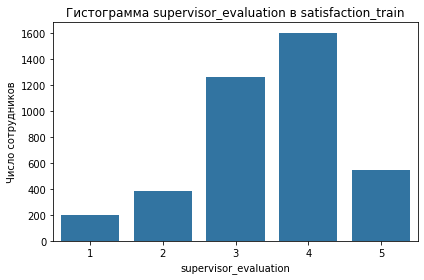

In [46]:
df = satisfaction_train

discrete_columns = ['employment_years', 'supervisor_evaluation']

for c in df.drop(discrete_columns, axis=1).select_dtypes(include='number'):
    if c=='id': continue
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=20)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число сотрудников')
    ax.set_title('Гистограмма '+c+' в satisfaction_train')
    fig.tight_layout()
    plt.show()
    
for c in discrete_columns:
    fig, ax = plt.subplots()
    sns.countplot(x=df[c], ax=ax, color='tab:blue')
    ax.set_xlabel(c)
    ax.set_ylabel('Число сотрудников')
    ax.set_title('Гистограмма '+c+' в satisfaction_train')
    fig.tight_layout()
    plt.show()

Целевой параметр `job_satisfaction_rate` распределен практически нормально

#### Категориальные переменные в `quit_train`

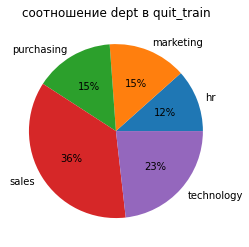

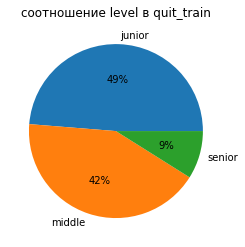

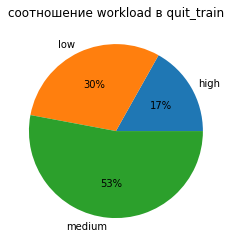

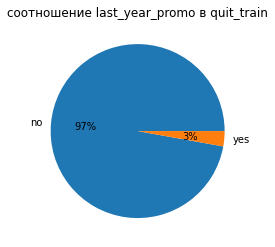

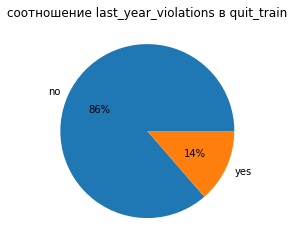

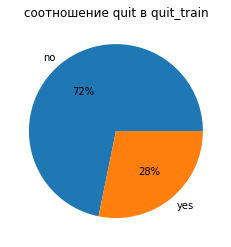

In [47]:
df = quit_train

for c in df.select_dtypes(include='object'):
    df.pivot_table(index=c, aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+c+' в quit_train')
    plt.show()

Для целевого параметра `quit` наблюдается явный дисбаланс классов

#### Количественные переменные в `quit_train`

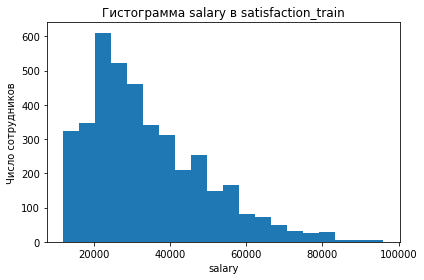

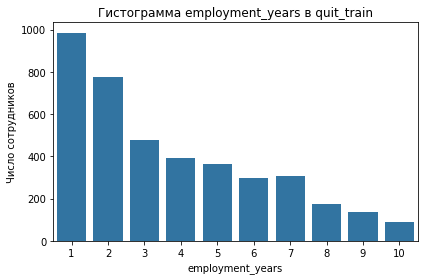

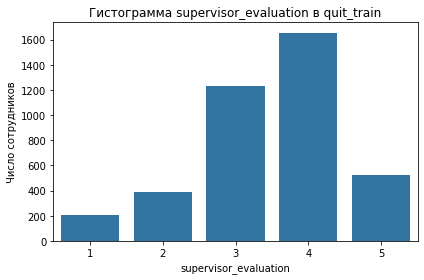

In [48]:
df = quit_train

for c in df.drop(discrete_columns, axis=1).select_dtypes(include='number'):
    if c=='id': continue
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=20)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число сотрудников')
    ax.set_title('Гистограмма '+c+' в satisfaction_train')
    fig.tight_layout()
    plt.show()
    
for c in discrete_columns:
    fig, ax = plt.subplots()
    sns.countplot(x=df[c], ax=ax, color='tab:blue')
    ax.set_xlabel(c)
    ax.set_ylabel('Число сотрудников')
    ax.set_title('Гистограмма '+c+' в quit_train')
    fig.tight_layout()
    plt.show()

#### Категориальные переменные в `test`

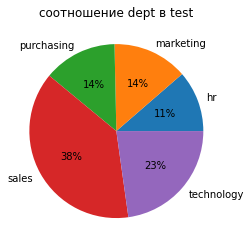

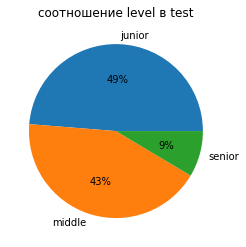

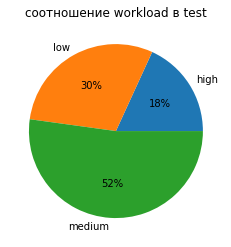

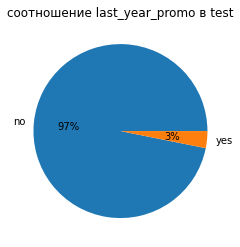

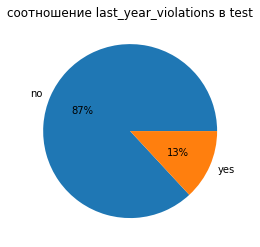

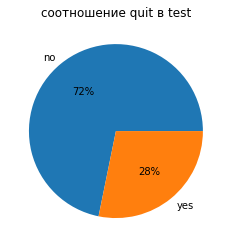

In [49]:
df = test

for c in df.select_dtypes(include='object'):
    df.pivot_table(index=c, aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+c+' в test')
    plt.show()

#### Количественные переменные в `test`

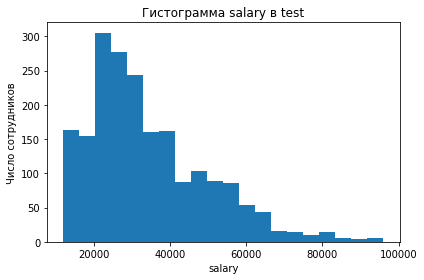

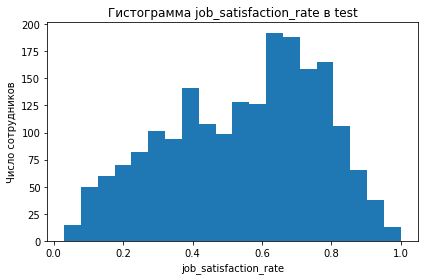

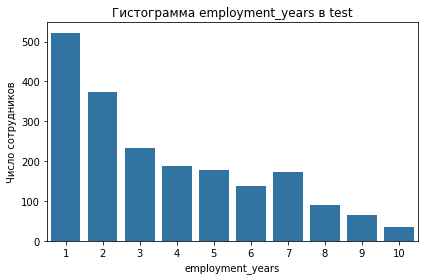

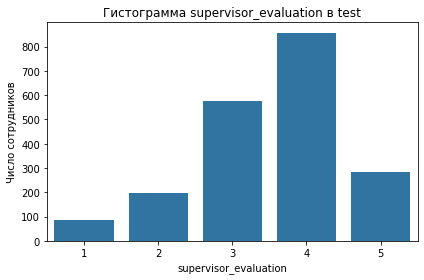

In [50]:
df = test

for c in df.drop(discrete_columns, axis=1).select_dtypes(include='number'):
    if c=='id': continue
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=20)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число сотрудников')
    ax.set_title('Гистограмма '+c+' в test')
    fig.tight_layout()
    plt.show()
    
for c in discrete_columns:
    fig, ax = plt.subplots()
    sns.countplot(x=df[c], ax=ax, color='tab:blue')
    ax.set_xlabel(c)
    ax.set_ylabel('Число сотрудников')
    ax.set_title('Гистограмма '+c+' в test')
    fig.tight_layout()
    plt.show()

#### Портрет уволившегося сотрудника

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
5,429973,purchasing,middle,medium,6,no,no,3,42000,yes,0.67
6,850699,technology,junior,medium,3,no,no,3,26400,yes,0.36
9,937235,sales,junior,medium,1,no,yes,3,26400,yes,0.22
10,354261,technology,junior,low,3,no,no,3,14400,yes,0.31
17,780847,sales,junior,low,1,no,no,2,14400,yes,0.24
...,...,...,...,...,...,...,...,...,...,...,...
1979,649355,marketing,junior,medium,3,no,no,3,22800,yes,0.33
1988,269983,sales,junior,medium,3,no,no,3,24000,yes,0.46
1995,393147,marketing,junior,low,3,no,no,3,20400,yes,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,yes,0.14


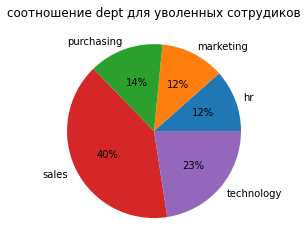

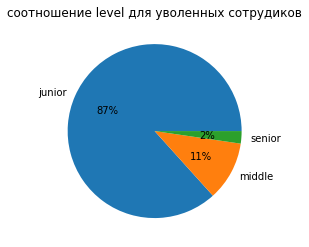

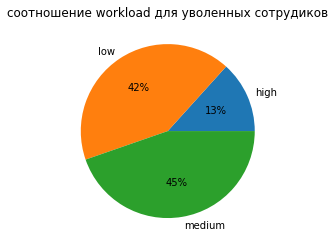

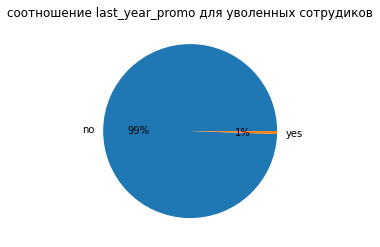

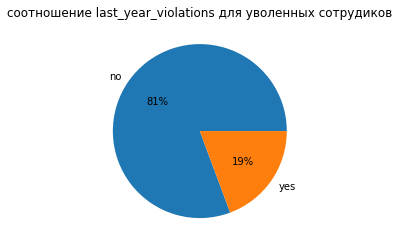

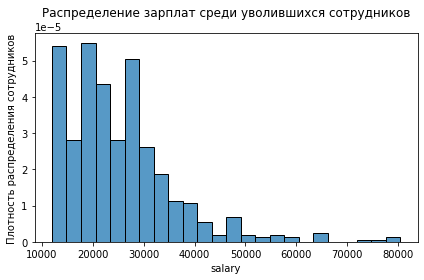

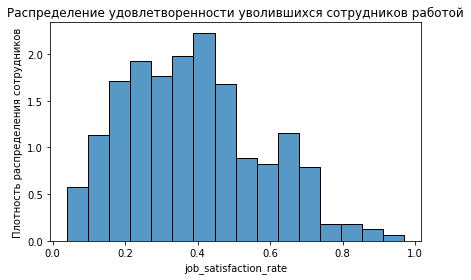

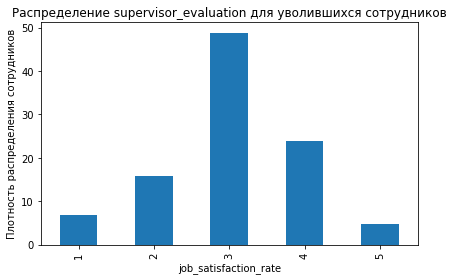

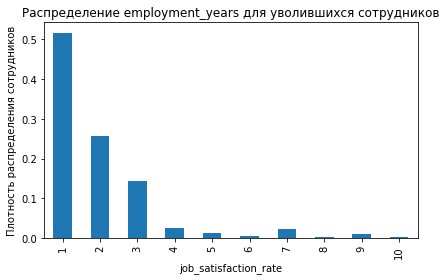

,Сотрудники,Средняя зарплата,Средний уровень удовлетворенности
0,уволившиеся,24955.319149,0.387713
1,все,34066.800000,0.548780


In [51]:
fired = test[test['quit']=='yes']

display(fired)

fired.pivot_table(index='dept', aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+'dept'+' для уволенных сотрудиков')
plt.show()

fired.pivot_table(index='level', aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+'level'+' для уволенных сотрудиков')
plt.show()

fired.pivot_table(index='workload', aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+'workload'+' для уволенных сотрудиков')
plt.show()

fired.pivot_table(index='last_year_promo', aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+'last_year_promo'+' для уволенных сотрудиков')
plt.show()

fired.pivot_table(index='last_year_violations', aggfunc='count').plot(y='id', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+'last_year_violations'+' для уволенных сотрудиков')
plt.show()

c = 'salary'
fig, ax = plt.subplots()
#ax.hist(fired[c], bins=20)
sns.histplot(fired[c],stat='density', common_norm=False, color='tab:blue')
ax.set_xlabel(c)
ax.set_ylabel('Плотность распределения сотрудников')
ax.set_title('Распределение зарплат среди уволившихся сотрудников')
fig.tight_layout()
plt.show()

c = 'job_satisfaction_rate'
fig, ax = plt.subplots()
#ax.hist(fired[c], bins=20)
sns.histplot(fired[c],stat='density', common_norm=False, color='tab:blue')
ax.set_xlabel(c)
ax.set_ylabel('Плотность распределения сотрудников')
ax.set_title('Распределение удовлетворенности уволившихся сотрудников работой')
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
(fired.value_counts('supervisor_evaluation', normalize=True, sort=False)*100).plot(kind='bar', ax=ax)
ax.set_xlabel(c)
ax.set_ylabel('Плотность распределения сотрудников')
ax.set_title('Распределение '+'supervisor_evaluation'+' для уволившихся сотрудников')
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
fired.value_counts('employment_years', normalize=True, sort=False).plot(kind='bar', ax=ax)
ax.set_xlabel(c)
ax.set_ylabel('Плотность распределения сотрудников')
ax.set_title('Распределение '+'employment_years'+' для уволившихся сотрудников')
fig.tight_layout()
plt.show()

display(pd.DataFrame([
    ['уволившиеся', fired['salary'].mean(), fired['job_satisfaction_rate'].mean()],
    ['все', test['salary'].mean(), test['job_satisfaction_rate'].mean()]
], columns = ['Сотрудники', 'Средняя зарплата', 'Средний уровень удовлетворенности']))

Получили, что изо всех отделов комании увольняются примерно одинаково (распределение для всех и для уволившихся сотрудников практически не отличаются).

Чаще всего увольняются джуниоры и сотрудники мало проработавшие в компании, хоть они и составляют половину от всех сотрудников, среди уволившихся джуниоров 87%, т.е. можно сказать что они увольняются вдвое чаще остальных

Также чаще всего увольняются работники с низкой и средней нагрузкой и невысокой ЗП.

Среди уволившихся сотрудников больше всего троешников по оценке руководителей, т.е. увольняются в основном средне оцененные сотрудники

Заметим также, что среди уволившихся сотрудников зарплата и уровень удовлетворенности работой заметно меньше средних по компании

#### Связь удовлетворенности сотрудника работой у увольнением

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это рассмотрев таблицу test т.к. она содержит оба этих параметра

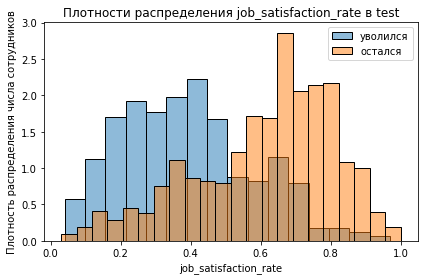

In [52]:
c = 'job_satisfaction_rate'
fig, ax = plt.subplots()
#ax.hist(test.loc[test['quit']=='yes',c], bins=20, alpha = 0.5, label='уволился')
#ax.hist(test.loc[test['quit']=='no',c], bins=20, alpha = 0.5, label='остался')
sns.histplot(test.loc[test['quit']=='yes',c],stat='density', common_norm=False, ax=ax, label='уволился', alpha=0.5)
sns.histplot(test.loc[test['quit']=='no',c],stat='density', common_norm=False, ax=ax, label='остался', color='tab:orange', alpha=0.5)
ax.legend()
ax.set_xlabel(c)
ax.set_ylabel('Плотность распределения числа сотрудников')
ax.set_title('Плотности распределения '+c+' в test')
fig.tight_layout()
plt.show()

Как видно средние для распределений уволившихся и оставшихся сотрудников отличаются. Для уволившихся среднее значение `job_satisfaction_rate` около 0.3, а для оставшихся около 0.7, при этом нет четкой границы по этому признаку между оставшимися и уволившимися сотрудниками.

Таким образом предположение о связи этих двух признаков подтверждается

### Корреляционный анализ

In [53]:
df = satisfaction_train.drop('id', axis=1)

interval_cols = df.drop(discrete_columns, axis=1).select_dtypes(include='number')

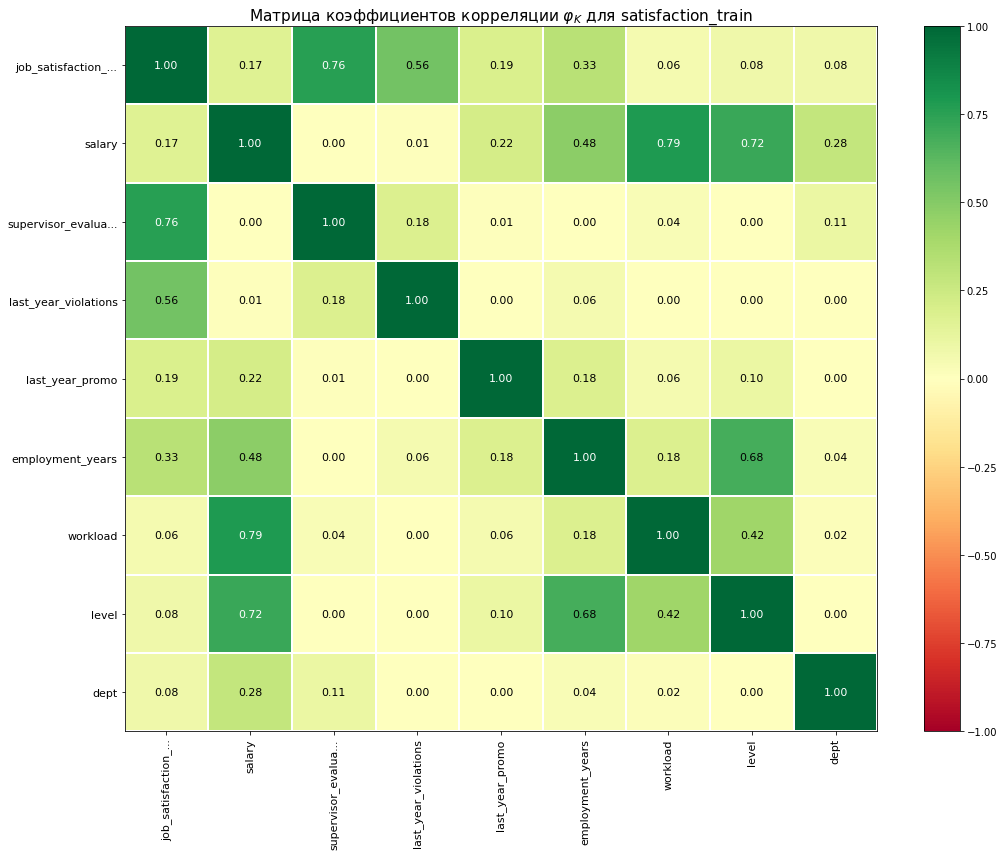

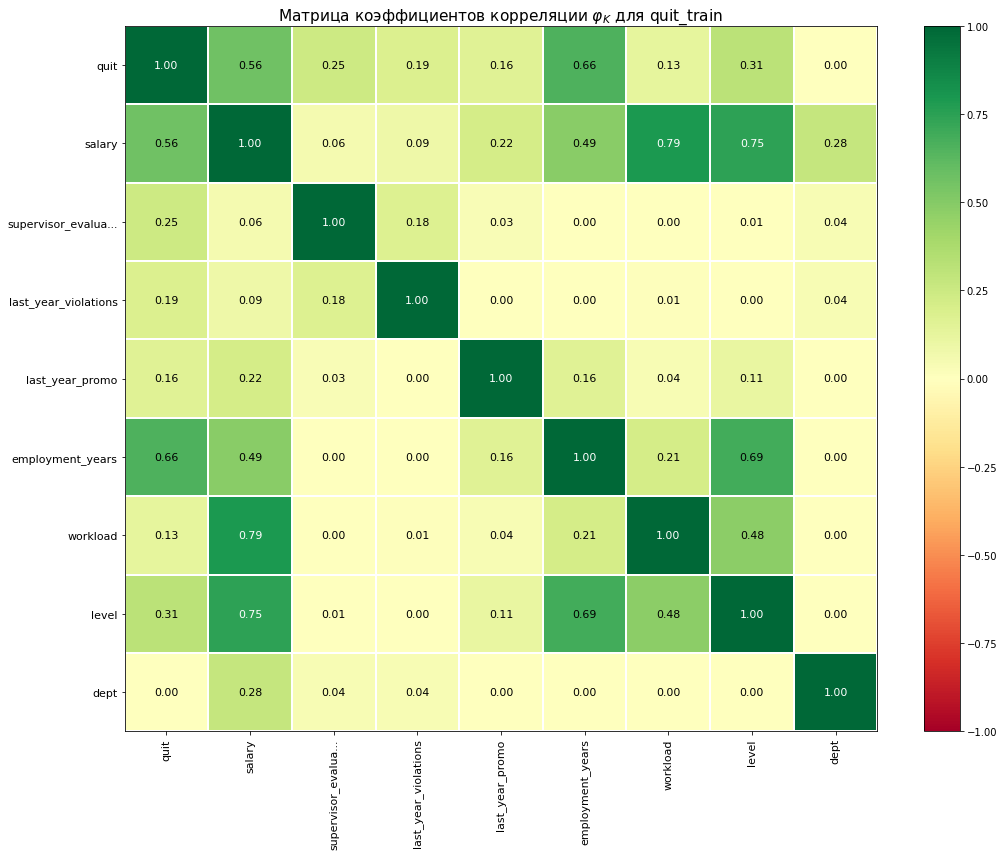

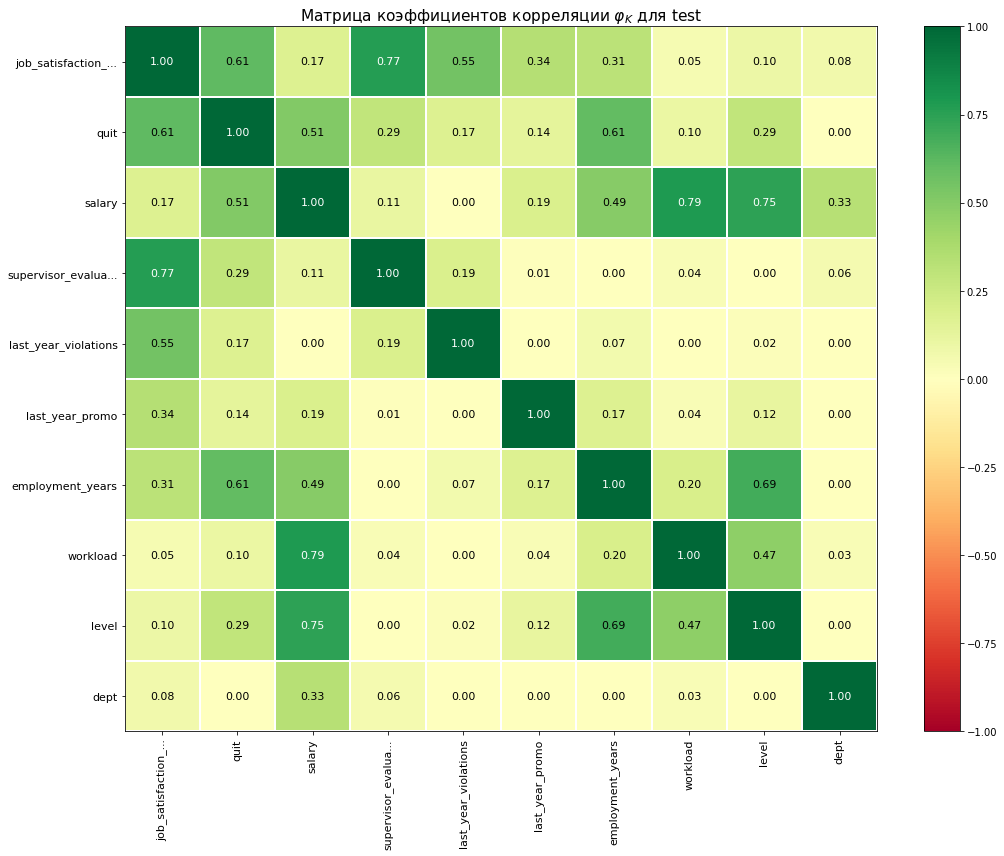

In [22]:
# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица коэффициентов корреляции $\varphi_K$ для satisfaction_train",
    fontsize_factor=1.1,
    figsize=(15, 12)
)

df = quit_train.drop('id', axis=1)

interval_cols = df.select_dtypes(include='number')

# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица коэффициентов корреляции $\varphi_K$ для quit_train",
    fontsize_factor=1.1,
    figsize=(15, 12)
)


df = test.drop('id', axis=1)

interval_cols = df.select_dtypes(include='number')

# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица коэффициентов корреляции $\varphi_K$ для test",
    fontsize_factor=1.1,
    figsize=(15, 12)
)

Есть сильно коррелирующие параметры, но назвать их мультиколлинеарными нельзя.

Утечки целевого признака нет

Коэффициент корреляции между `job_satisfaction_rate` и `quit` равен 0.61, что еще раз подтверждает связь этих признаков

### Предсказание уровня удовлетворённости сотрудника

В данном разделе обучим несколько моделей регресии для целевого параметра `job_satisfaction_rate` (уровень удовлетворенности сотрудника) и выберем из них лучшую

Для оценки качества модели будем использовать метрику SMAPE:
$$SMAPE = \frac{100}{n} \sum_{i=1}^{n} \frac{|y_i-y_{i,pred}|}{(|y_i|+|y_{i,pred}|)/2}$$

#### Подготовка данных

Входные признаки можно разделить на 3 группы:
- Количественные: `employment_years`, `supervisor_evaluation`, `salary`
- Категориальные ранжированные: `level`, `workload`
- Категориальные: `dept`, `last_year_promo`, `last_year_violations`

Количественные признаки будут масштабированы с помощью StandardScaler, категориальные признаки будут закодированы OHE и OrdinalEncoder, причем будет учтено ранжирование

Также в данном разделе заполним пропуски, обнаруженные в ходе предобработки.

In [23]:
num_columns = satisfaction_train.drop(['id', 'job_satisfaction_rate'], axis=1).select_dtypes(include='number').columns
print(num_columns)
ranged_columns = satisfaction_train[['level', 'workload']].columns
print(ranged_columns)
cat_columns = satisfaction_train.drop(['id', 'job_satisfaction_rate', 'level', 'workload'], axis=1).select_dtypes(include='object').columns
print(cat_columns)

categories=[
        ['junior', 'middle', 'senior'],
        ['low', 'medium', 'high']
]
################################################
encoder_pipe = Pipeline(
    [
        ('fillna1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ('fillna2', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )
################################################
ranged_encoder_pipe = Pipeline(
    [
        ('fillna1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ('fillna2', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )
################################################
scaler_pipe = Pipeline(
    [
        ('scale', MinMaxScaler())
    ]
    )
################################################
data_preprocessor = ColumnTransformer(
    [
        ('encoder', encoder_pipe, cat_columns),
        ('ranged_encoder', ranged_encoder_pipe, ranged_columns),
        ('scaler', scaler_pipe, num_columns)
    ], 
    remainder='passthrough'
)
################################################
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
################################################
parameters = [
    #KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, 20),
        'models__weights':["uniform", "distance"],
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    },
    #DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__criterion':['squared_error', 'friedman_mse', 'absolute_error','poisson'],
        #'models__max_depth': range(2, 30),
        'models__max_depth': [None] + [i for i in range(2, 10)],
        'models__min_samples_split':range(2,40),
        'models__min_samples_leaf':range(1,40),
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    },
    #LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    }
] 

Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object')
Index(['level', 'workload'], dtype='object')
Index(['dept', 'last_year_promo', 'last_year_violations'], dtype='object')


In [24]:
warnings.filterwarnings('ignore') # чтобы не лезли предупреждения

In [25]:
def smape(y1, y2):
    return 200*np.mean(  abs(y1-y2)/(abs(y1)+abs(y2))  )

SMAPE = make_scorer(smape, greater_is_better=False)

Проверим данные для обучения (таблица `satisfaction_train` с удаленными `id`) на наличие дубликатов, т.к. их присутствие не улучшает тренировочную выборку

In [26]:
X_y_train_satisfaction = satisfaction_train.drop(['id'], axis=1)

print('Дубликаты в обучающей выборке:', X_y_train_satisfaction.duplicated().sum())

Дубликаты в обучающей выборке: 245


Дубликаты обнаружились, удалим их

In [27]:
X_y_train_satisfaction = X_y_train_satisfaction.drop_duplicates()

#### Обучение и тестирование модели

In [28]:
grid_search = RandomizedSearchCV(
    pipe_final, 
    parameters, 
    cv = 5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=300,
    scoring=SMAPE
)

grid_search.fit(X_y_train_satisfaction.drop('job_satisfaction_rate', axis=1), X_y_train_satisfaction['job_satisfaction_rate'])

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('encoder',
                                                                               Pipeline(steps=[('fillna1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encode',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore')),
                                                                                               ('fillna2',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               Index(['dept', 'last_year_promo',...
                                         'preprocessor__ranged_encoder__encode': [OneHotEncoder(handle_unknown='ignore'),
                                                                                  OrdinalEncoder(categories=[['junior',
                                                                                                              'middle',
                                                                                                              'senior'],
                                                                                                             ['low',
                                                                                                              'medium',
                                                                                                              'high']],
                                                                                                 handle_unknown='use_encoded_value',
                                                                                                 unknown_value=nan)],
                                         'preprocessor__scaler__scale': [StandardScaler(),
                                                                         MinMaxScaler()]}],
                   random_state=2024,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [29]:
#print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('Лучшая модель и её параметры:\n\n', grid_search.best_params_)

print ('Метрика лучшей модели при кросс-валидации:', abs(grid_search.best_score_))

Лучшая модель и её параметры:

 {'preprocessor__scaler__scale': StandardScaler(), 'preprocessor__ranged_encoder__encode': OrdinalEncoder(categories=[['junior', 'middle', 'senior'],
                           ['low', 'medium', 'high']],
               handle_unknown='use_encoded_value', unknown_value=nan), 'preprocessor__encoder__encode': OneHotEncoder(handle_unknown='ignore'), 'models__min_samples_split': 2, 'models__min_samples_leaf': 3, 'models__max_depth': None, 'models__criterion': 'friedman_mse', 'models': DecisionTreeRegressor(random_state=2024)}
Метрика лучшей модели при кросс-валидации: 14.95535201800995


In [30]:
X_test, y_test = test.drop(['id', 'job_satisfaction_rate', 'quit'], axis=1), test['job_satisfaction_rate']

#прогноз на тестовых данных
y_test_pred = grid_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred)}')

Метрика SMAPE на тестовой выборке: 13.631879391931061


Лучший результат показала модель 
- DecisionTreeRegressor(criterion='friedman_mse', max_depth=None, min_samples_leaf=3, min_samples_split=2) с кодировшиками OHE и OrdinalEncoder, скейлером StandardScaler

Метрика SMAPE лучшей модели на тестовой выборке: 13.6%, что немного лучше чем на тренировочной выборке. Исходя из описания входных параметров, утечки целевого признака быть не должно, вероятнее всего тестовые данные просто немного лучшего качества чем тренировочные.

#### Проверка модели на адекватность

Сравним лучшую обученную модель с константной моделью (возвращает среднее значение)

In [31]:
dummy = DummyRegressor()

dummy.fit(X_y_train_satisfaction.drop('job_satisfaction_rate', axis=1), X_y_train_satisfaction['job_satisfaction_rate'])

dummy_pred = dummy.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке для константной модели: {smape(y_test, dummy_pred)}')

Метрика SMAPE на тестовой выборке для константной модели: 38.26225790202237


Как видно константная модель показала заметно худший результат, таким образом обученную модель можно считать адекватной

#### Выводы по предсказанию уровня удовлетворенности сотрудника

In [32]:
display(pd.DataFrame({'features':grid_search.best_estimator_[0].get_feature_names_out(),'importance':grid_search.best_estimator_[1].feature_importances_}).sort_values(by='importance', ascending=False))

,features,importance
12,scaler__supervisor_evaluation,0.667816
13,scaler__salary,0.085659
11,scaler__employment_years,0.074550
7,encoder__last_year_violations_no,0.053801
9,ranged_encoder__level,0.047694
10,ranged_encoder__workload,0.018829
3,encoder__dept_sales,0.011222
4,encoder__dept_technology,0.009013
0,encoder__dept_hr,0.008319
6,encoder__last_year_promo_yes,0.008158


В данном разделе было обучено несколько моделей регрессии с различными гиперпараметрами. Лучше всего себя показала модель DecisionTreeRegressor c метрикой SMAPE на тестовой выборке 13.6%, что удовлетворяют требованиям заказчика (не менее 15%)

Наиболее важными признаками для данной модели являются:
- `supervisor_evaluation`
- `salary`
- `employment_years`
- `last_year_violations_no`
- `level`

### Предсказание увольнения сотрудника

В данном разделе обучим несколько моделей бинарной классификации для целевого параметра `quit` (увольнение сотрудника) и выберем из них лучшую

Для оценки качества модели будем использовать метрику ROC-AUC

#### Подготовка данных

Входные признаки и методы их обработки для этой задачи те же самые что и для предыдущей, но также попробуем добавить новый входной признак `job_satisfaction_rate`, расчитанный для тренировочной выборки с помощью модели из предыдущего раздела.

Для корректной работы моделей и метрик кодируем целевой параметр `quit` с помощью LabelEncoder

Также при настройке моделей будем учитывать дисбаланс классов

In [33]:
# пайплайн остается тот же

# кодируем целевой параметр для корректной работы моделей и метрик
le = LabelEncoder()

quit_train['quit'] = le.fit_transform(quit_train['quit'])
test['quit'] = le.transform(test['quit'])

In [34]:
parameters_quit = [
    #KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    },
    #DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE,class_weight='balanced')],
        'models__max_depth': range(2, 11),
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    },
    #SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,class_weight='balanced', probability=True)],
        'models__C': [0.1, 0.3, 0.7, 1, 1,5, 2, 3],
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    },
    #LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1', solver='saga',class_weight='balanced')],
        'models__C': [0.1, 0.3, 0.7, 1, 1.5, 2, 3, 5],
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    }
]

Как и для предыдущей модели проверим тренировочные данные на наличие дубликатов и удалим их

In [35]:
X_y_train_quit = quit_train.drop(['id'], axis=1)
print('Дубликаты в тренировочных данных:', X_y_train_quit.duplicated().sum())
X_y_train_quit = X_y_train_quit.drop_duplicates()

Дубликаты в тренировочных данных: 1413


#### Обучение и тестирование модели

In [36]:
grid_search_quit = RandomizedSearchCV(
    pipe_final, 
    parameters_quit, 
    cv = 5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=200,
    scoring='roc_auc'
)

grid_search_quit.fit(X_y_train_quit.drop('quit', axis=1), X_y_train_quit['quit'])

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('encoder',
                                                                               Pipeline(steps=[('fillna1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encode',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore')),
                                                                                               ('fillna2',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               Index(['dept', 'last_year_promo',...
                                                                           OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                          unknown_value=nan)],
                                         'preprocessor__ranged_encoder__encode': [OneHotEncoder(handle_unknown='ignore'),
                                                                                  OrdinalEncoder(categories=[['junior',
                                                                                                              'middle',
                                                                                                              'senior'],
                                                                                                             ['low',
                                                                                                              'medium',
                                                                                                              'high']],
                                                                                                 handle_unknown='use_encoded_value',
                                                                                                 unknown_value=nan)],
                                         'preprocessor__scaler__scale': [StandardScaler(),
                                                                         MinMaxScaler()]}],
                   random_state=2024, scoring='roc_auc')

In [37]:
#print('Лучшая модель и её параметры:\n\n', grid_search_quit.best_estimator_)
print('Лучшая модель и её параметры:\n\n', grid_search_quit.best_params_)

print ('Метрика лучшей модели при кросс-валидации:', abs(grid_search_quit.best_score_))

Лучшая модель и её параметры:

 {'preprocessor__scaler__scale': StandardScaler(), 'preprocessor__ranged_encoder__encode': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__encoder__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=nan), 'models__C': 2, 'models': SVC(class_weight='balanced', probability=True, random_state=2024)}
Метрика лучшей модели при кросс-валидации: 0.907601440070495


Для входных признаков без `job_satisfaction_rate` лучше всего себя показала модель 
- SVC(C=2) c кодировшиком OHE для ранжированных признаков, OrdinalEncoder для категоральных и скейлером StandardScaler

Метрика ROC-AUC при кросс-валидации 0.908.

#### Добавление нового признака в модель

Теперь добавим ко входным признакам признак `job_satisfaction_rate` и снова обучим модели

In [39]:
# Добавляем признак job_satisfaction_rate ко входным
num_columns_new = satisfaction_train.drop(['id'], axis=1).select_dtypes(include='number').columns
################################################
# Обновляем пайплайн

data_preprocessor_new = ColumnTransformer(
    [
        ('encoder', encoder_pipe, cat_columns),
        ('ranged_encoder', ranged_encoder_pipe, ranged_columns),
        ('scaler', scaler_pipe, num_columns_new)
    ], 
    remainder='passthrough'
)
################################################
pipe_final_new = Pipeline([
    ('preprocessor', data_preprocessor_new),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
################################################
# Рассчитываем job_satisfaction_rate для quit_train

X_y_train_quit_new = quit_train.drop('id', axis=1)
X_y_train_quit_new['job_satisfaction_rate'] = grid_search.predict(X_y_train_quit_new)

# проверяем тренировочные данные на дубликаты
print('Дубликаты в новых тренировочных данных:', X_y_train_quit_new.duplicated().sum())
X_y_train_quit_new = X_y_train_quit_new.drop_duplicates()

Дубликаты в новых тренировочных данных: 1413


#### Обучение и тестирование обновленной модели

In [40]:
# Обучение модели

grid_search_quit_new = RandomizedSearchCV(
    pipe_final_new, 
    parameters_quit, 
    cv = 5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100,
    scoring='roc_auc'
)

grid_search_quit_new.fit(X_y_train_quit_new.drop('quit', axis=1), X_y_train_quit_new['quit'])

#print('Лучшая модель и её параметры:\n\n', grid_search_quit_new.best_estimator_)
print('Лучшая модель и её параметры:\n\n', grid_search_quit_new.best_params_)

print ('Метрика лучшей модели при кросс-валидации:', abs(grid_search_quit_new.best_score_))

#X_test_quit, y_test_quit = test.drop(['id', 'quit'], axis=1), test['quit']

#прогноз на тестовых данных
#y_test_pred = grid_search_quit_new.best_estimator_[1].predict_proba(grid_search_quit_new.best_estimator_[0].transform(X_test_quit))[:,1]

#print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred)}')

Лучшая модель и её параметры:

 {'preprocessor__scaler__scale': MinMaxScaler(), 'preprocessor__ranged_encoder__encode': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__encoder__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=nan), 'models__C': 5, 'models': SVC(class_weight='balanced', probability=True, random_state=2024)}
Метрика лучшей модели при кросс-валидации: 0.913491038549562


Для входных признаков с добавлением `job_satisfaction_rate` лучше всего себя показала модель 
- SVC(C=5) c кодировшиком OHE для ранжированных признаков, OrdinalEncoder для категоральных и скейлером MinMaxScaler

Метрика ROC-AUC при кросс валидации 0.913, что лучше чем у модели без добавления нового признака. Таким образом эта модель является лучшей.

Рассчитаем метрику лучшей модели на тестовой выборке

In [41]:
X_test_quit, y_test_quit = test.drop(['id', 'quit'], axis=1), test['quit']

#прогноз на тестовых данных
y_test_pred = grid_search_quit_new.best_estimator_[1].predict_proba(grid_search_quit_new.best_estimator_[0].transform(X_test_quit))[:,1]

print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred)}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9268709624844426


Метрики при кросс-валидации и на тестовой выборке близки, что говорит об отсутствии переобучения модели.

#### Проверка модели на адекватность

Сравним лучшую обученную модель со случайной моделью (возвращает случайный класс с учетом стратификации)

In [42]:
dummy = DummyClassifier(strategy='stratified')

dummy.fit(X_y_train_quit_new.drop('quit',axis=1), X_y_train_quit_new['quit'])

dummy_pred = dummy.predict_proba(X_test_quit)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке для случайной модели: {roc_auc_score(y_test_quit, dummy_pred)}')

Метрика ROC-AUC на тестовой выборке для случайной модели: 0.5029139256010589


Как видно случайная модель показаля себя заметно хуже лучшей обученной, таким образом можно считать обученную модель адекватной.

#### Выводы по предсказанию увольнения сотрудников

In [43]:
tr = grid_search_quit_new.best_estimator_[0]
model = grid_search_quit_new.best_estimator_[1]

# для ускорения расчетов применяем shap только к небольшой выборке
X_test_tr = tr.transform(X_test_quit)
indices = np.random.choice(X_test_tr.shape[0], 300, replace=False)
X_test_tr = X_test_tr[indices]

# это будет долго
explainer = shap.Explainer(model.predict, X_test_tr, feature_names=tr.get_feature_names_out())
shap_values = explainer(X_test_tr)

PermutationExplainer explainer: 301it [05:56,  1.21s/it]                         


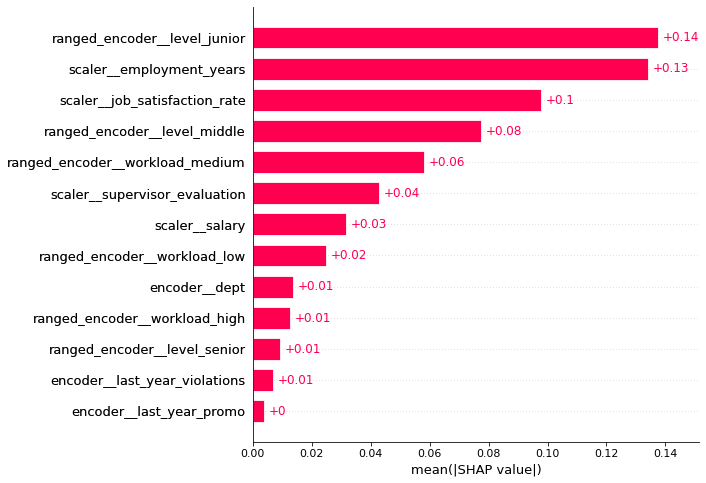

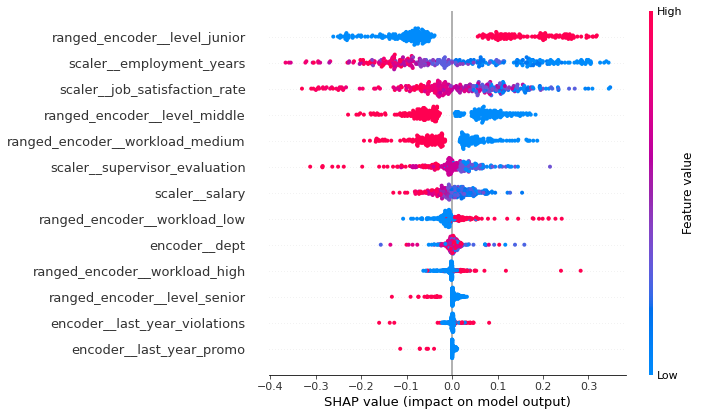

In [44]:
shap.plots.bar(shap_values, max_display=30) 
shap.plots.beeswarm(shap_values, max_display=30) 

В данном разделе было обучено несколько моделей бинарной классификации и оценено их качество метрикой ROC-AUC. Лучше всего себя показала модель SVC с добавлением нового входного признака `job_satisfaction_rate` (рассчитанного моделью из прошлой главы). Значение метрики для этой модели на тестовых данных: 0.927, что удовлетворяет требованиям заказчика (не менее 0.91).

Методом SHAP было получено, что наиболее значимыми признаками являются:
- `level_junior` (чем больше тем выше вероятность увольнения)
- `employment_years` (чем меньше тем выше вероятность увольнения)
- `job_satisfaction_rate` (чем меньше тем выше вероятность увольнения)
- `level_middle` (чем меньше тем выше вероятность увольнения)
- `workload_medium` (чем меньше тем выше вероятность увольнения)
- `superviser_evaluation` (чем меньше тем выше вероятность увольнения)

## Выводы

В данной работе рассматривались данные о сотрудниках компании и их удовлетворенности работой. Целью работы было обучение двух моделей для:
- предсказания удовлетворенности сотрудника работой
- предсказания увольнения с работы.

В ходе предобработки данных были обнаружены и заполнены модой пропуски в категориальных типах, в целом качесво данных можно оценить как хорошее.

Для каждой из задач машинного обучения было обучено несколько моделей среди которых были выбраны лучшие:
- предсказание удовлетворенности сотрудника работой: DecisionTreeRegressor, значение метрики SMAPE = 13.6% 
- предсказание увольнения с работы: SVC, значение метрики ROC-AUC = 0.932

Причем для второй к исходным входным признакам был добавлен признак `job_satisfaction_rate`, который при отсутствии во входных данных может быть рассчитан первой моделью.

Для задачи предсказания удовлетворенности сотрудника работой наиболее значимы следующие признаки:
- `supervisor_evaluation`
- `salary`
- `employment_years`
- `last_year_violations_no`
- `level`

Для задачи предсказания увольнения наиболее значимыми признаками являются:
- `level_junior` (чем больше тем выше вероятность увольнения)
- `employment_years` (чем меньше тем выше вероятность увольнения)
- `job_satisfaction_rate` (чем меньше тем выше вероятность увольнения)
- `level_middle` (чем меньше тем выше вероятность увольнения)
- `workload_medium` (чем меньше тем выше вероятность увольнения)
- `superviser_evaluation` (чем меньше тем выше вероятность увольнения)

В ходе рассмотрения портрета уволившегося сотрудника было выяснено, что чаще всего увольняются джуниоры и сотрудники с небольшим сроком работы в компании, причем независимо от департамента и рабочей нагрузки. Также можно заметить, что среди уволившихся сотрудников много небольших зарплат и средней (3) оценки их работы руководством.

Таким образом для удержания сотрудников можно порекомендовать повысить зарплаты джуниорам и обговорить с руководителями отделов критерии оценки работы сотрудиков

